In [3]:
import cv2
import os
import sys
sys.path.append("/shareb/zliu/analysis/")

from CHARMtools import Cell3D
import imp
imp.reload(Cell3D)

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd




import glob
import re



import cooler
from scipy import stats


import scipy
from scipy.stats import pearsonr, spearmanr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

import multiprocessing


/tmp/ipykernel_172786/92455773.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [78]:
def mat_cor(pair):
    mat1, mat2 = pair

    # 去掉对角线，不考虑
    np.fill_diagonal(mat1, np.nan)
    np.fill_diagonal(mat2, np.nan)
    #
    mat1[mat1==np.inf] = np.nan
    mat1[mat1==-np.inf] = np.nan

    mat2[mat2==np.inf] = np.nan
    mat2[mat2==-np.inf] = np.nan

    # Calculate distance matrices
    distance_matrix_1 = mat1.flatten()
    distance_matrix_2 = mat2.flatten()

    # Replace inf values with nan
    distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
    distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)
    distance_matrix_1 = distance_matrix_1[mask]
    distance_matrix_2 = distance_matrix_2[mask]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr and spearmanr
    pearsonr_value, _ = pearsonr(distance_matrix_1, distance_matrix_2)
    spearmanr_value, _ = spearmanr(distance_matrix_1, distance_matrix_2)

    # For ssim and mse, we first need to handle matrices properly since they might contain NaNs now
    # Normalize matrices after setting NaNs to 0 for these calculations
    mat1_norm = np.nan_to_num((mat1 - np.nanmean(mat1)) / np.nanstd(mat1), nan=0)
    mat2_norm = np.nan_to_num((mat2 - np.nanmean(mat2)) / np.nanstd(mat2), nan=0)

    ssmis = ssim(mat1_norm, mat2_norm)
    mse = mean_squared_error(mat1_norm, mat2_norm)

    return [pearsonr_value, spearmanr_value, ssmis, mse]


def violinplot_charts(pearson_list, spearman_list, ssmi_list, mse_list,title,colors):
    # 设置图表的大小
    plt.figure(figsize=(12, 4))
    
    # 绘制Pearson相关系数的小提琴图
    plt.subplot(1, 4, 1)  # 第一行第一列
    sns.violinplot(data=pearson_list, palette=colors)
    #设置x刻度名称，加上"group"
    plt.xticks(np.arange(len(pearson_list)), ['Group1', 'Group2', 'Group3', 'Group4'])
    plt.title('Pearson', fontsize=16)

    # 绘制Spearman相关系数的小提琴图
    plt.subplot(1, 4, 2)  # 第一行第二列
    sns.boxplot(data=spearman_list, palette=colors)
    plt.xticks(np.arange(len(spearman_list)), ['Group1', 'Group2', 'Group3', 'Group4'])
    plt.title('Spearman', fontsize=16)

    # 绘制SSIM的小提琴图
    plt.subplot(1,4, 3)  # 第二行第一列
    sns.boxplot(data=ssmi_list, palette=colors,)
    plt.xticks(np.arange(len(ssmi_list)), ['Group1', 'Group2', 'Group3', 'Group4'])
    plt.title('SSIM', fontsize=16)

    # 绘制MSE的小提琴图
    plt.subplot(1, 4, 4)  # 第二行第二列
    sns.boxplot(data=mse_list, palette=colors)
    plt.xticks(np.arange(len(mse_list)), ['Group1', 'Group2', 'Group3', 'Group4'])
    plt.title('MSE', fontsize=16)

    # 调整子图之间的间距
    plt.tight_layout()
    #设置总的标题
    plt.suptitle(title, fontsize=16)

    # 显示图表
    plt.show()

#一个新的plot函数
def plot_boxplot(list1,list2,title):
    colors = ["#b3b3b3","#e5c494"]
    plt.figure(figsize=(4, 4))
    sns.violinplot(data=[list1,list2], palette=colors)
    #不显示x刻度
    plt.xticks([])
    plt.title(title, fontsize=16)
    
def plot_groups(pearson_list
                ,spearman_list
                ,ssmi_list
                ,mse_list
                ,title
                ,xlist):
    # 设置图表的大小
    plt.figure(figsize=(30, 4))
    colors = ["#b3b3b3","#d01c8b","#df65b0","#e7d4e8","#af8dc3","#756bb1","#41b6c4","#ffffb2","#fed976","#feb24c","#01665e","##fb9a99"]
    # 绘制Pearson相关系数的小提琴图
    plt.subplot(1, 4, 1)  # 第一行第一列
    sns.boxplot(data=pearson_list, palette=colors)
    #设置x刻度名称，加上"group"
    plt.title('Pearson', fontsize=16)
    plt.xticks(range(len(xlist)), xlist,rotation=45)

    # 绘制Spearman相关系数的小提琴图
    plt.subplot(1, 4, 2)  # 第一行第二列
    sns.boxplot(data=spearman_list, palette=colors)
    plt.title('Spearman', fontsize=16)
    plt.xticks(range(len(xlist)), xlist,rotation=45)

    # 绘制SSIM的小提琴图
    plt.subplot(1,4, 3)  # 第二行第一列
    sns.boxplot(data=ssmi_list, palette=colors)
    plt.title('SSIM', fontsize=16)
    plt.xticks(range(len(xlist)), xlist,rotation=45)

    # 绘制MSE的小提琴图
    plt.subplot(1, 4, 4)  # 第二行第二列
    sns.boxplot(data=mse_list, palette=colors)
    plt.title('MSE', fontsize=16)
    plt.xticks(range(len(xlist)), xlist,rotation=45)

def calculate_correlations(pair):
    matrix1, matrix2 = pair
    
    num_bins = matrix1.shape[0]
    pearson_correlations = []
    spearman_correlations = []
    distances = []
    
    for d in range(num_bins):
        diag1 = np.diagonal(matrix1, offset=d)
        diag2 = np.diagonal(matrix2, offset=d)
        
        # Ignore distances with less than 2 points
        if len(diag1) < 2:
            continue
        
        pearson_corr, _ = pearsonr(diag1, diag2)
        spearman_corr, _ = spearmanr(diag1, diag2)
        
        pearson_correlations.append(pearson_corr)
        spearman_correlations.append(spearman_corr)
        distances.append(d)
    
    return distances, pearson_correlations, spearman_correlations

def plot_Distance_cor(x,y1,y2,y3,y4,title,colorlist):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x, y=y1, label='group1',c=colorlist[0])
    sns.lineplot(x=x, y=y2, label='group2',c=colorlist[1])
    sns.lineplot(x=x, y=y3, label='group3',c=colorlist[2])
    sns.lineplot(x=x, y=y4, label='group4',c=colorlist[3])
    plt.xlabel('Stratum')
    plt.ylabel('Correlation')
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
colors_cell = ["#edf8e9", "#bae4b3", "#74c476", "#238b45"]
colors_science = ["#eff3ff", "#bdd7e7", "#6baed6", "#2171b5"]

## Raw data

In [7]:
target = "Cell2020"
group_list = np.arange(1,5)
#ground truth
prob_matrix_science = np.load(f"/shareb/mliu/evaluate_impute/data/simulation_hic/{target}/prob/{target}_prob_matrix.npy")
print("loaded")
print(prob_matrix_science.shape)
downsample_matrix_dir  = f"/shareb/mliu/evaluate_impute/data/simulation_hic/{target}/hic/matrix"

loaded
(3029, 243, 243)


In [11]:
distance_pearson_list = []
distance_spearman_list = []

for group in group_list:
    print(f"group{group}")
    matrix_path = f"{downsample_matrix_dir}/{target}_sample_matrix{group}.npy"
    matrix_raw = np.load(matrix_path)[0:100,:]
    print(matrix_raw.shape)
    pairs = [(prob_matrix_science[i], matrix_raw[i]) for i in range(matrix_raw.shape[0])]
    with multiprocessing.Pool(20) as pool:
        results = pool.map(calculate_correlations, pairs)
    distance,pearsons,spearmans = zip(*results)
    pearson_means = np.nanmean(pearsons, axis=0)
    spearman_means = np.nanmean(spearmans, axis=0)
    distance_pearson_list.append(pearson_means)
    distance_spearman_list.append(spearman_means)

group1
(100, 243, 243)
group2
(100, 243, 243)
group3
(100, 243, 243)
group4
(100, 243, 243)


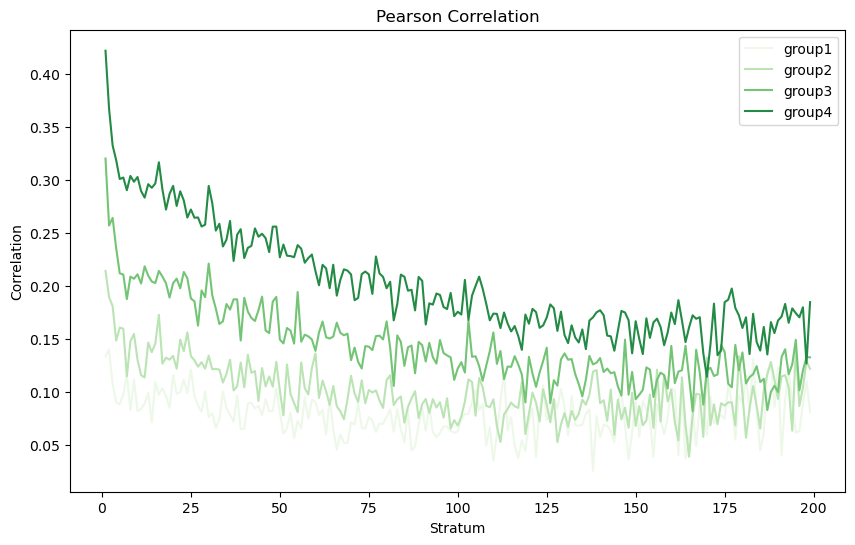

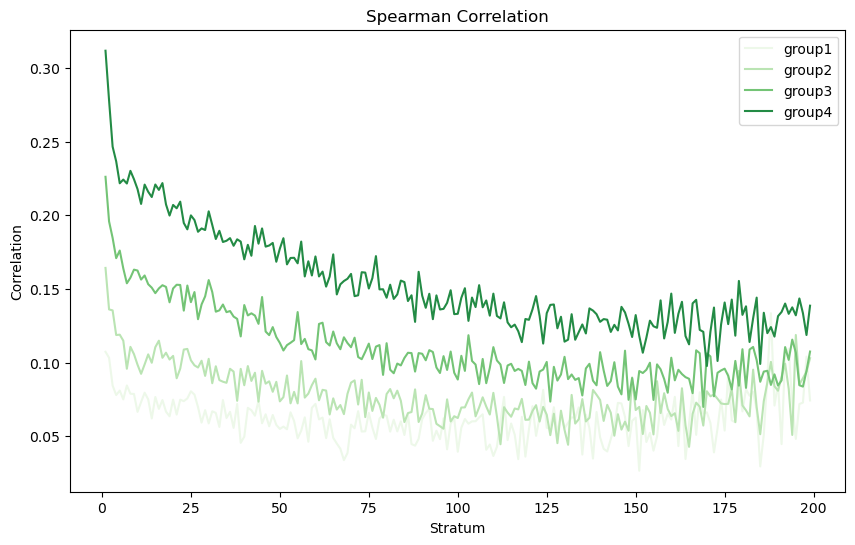

In [14]:
plot_Distance_cor(distance[0][0:200],distance_pearson_list[0][0:200],distance_pearson_list[1][0:200],distance_pearson_list[2][0:200],distance_pearson_list[3][0:200],"Pearson Correlation",colors_cell)
plot_Distance_cor(distance[0][0:200],distance_spearman_list[0][0:200],distance_spearman_list[1][0:200],distance_spearman_list[2][0:200],distance_spearman_list[3][0:200],"Spearman Correlation",colors_cell)

In [47]:
pearson_list_raw = []
spearman_list_raw = []
ssmi_list_raw = []
mse_list_raw = []

for group in group_list:
    print(f"group{group}")
    matrix_path = f"{downsample_matrix_dir}/{target}_sample_matrix{group}.npy"
    matrix_raw = np.load(matrix_path)[0:100,:]
    pairs = [(prob_matrix_science[i], matrix_raw[i]) for i in range(matrix_raw.shape[0])]

    with multiprocessing.Pool(20) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_raw.append(pearsons_raw)
    spearman_list_raw.append(spearmans_raw)
    ssmi_list_raw.append(ssmis_raw)
    mse_list_raw.append(mses_raw)


group1


group2
group3
group4


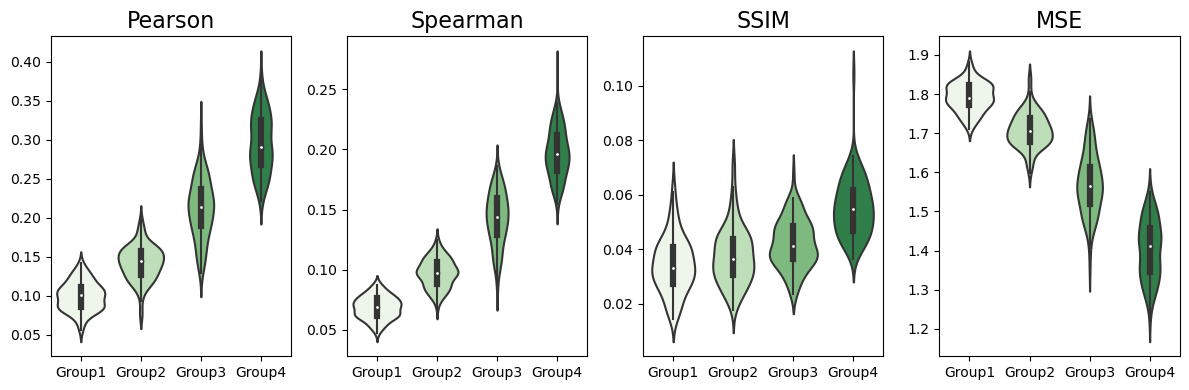

In [27]:
violinplot_charts(pearson_list_raw, spearman_list_raw, ssmi_list_raw, mse_list_raw,None,colors_cell)

In [16]:
#config
target = "Cell2020"
prob_matrix = np.load(f"/shareb/mliu/evaluate_impute/data/simulation_hic/{target}/prob/{target}_prob_matrix.npy")

## 1-hicrep

In [17]:
group_list = np.arange(1,5)
pearson_list_hicrep = []
spearman_list_hicrep = []
ssmi_list_hicrep = []
mse_list_hicrep = []
for group in group_list:
    print(f"group{group}")
    matrix_hicluster = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/hicrep/hicrep_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_hicluster[i]) for i in range(matrix_hicluster.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_hicrep.append(pearsons_raw)
    spearman_list_hicrep.append(spearmans_raw)
    ssmi_list_hicrep.append(ssmis_raw)
    mse_list_hicrep.append(mses_raw)

group1


group2
group3
group4


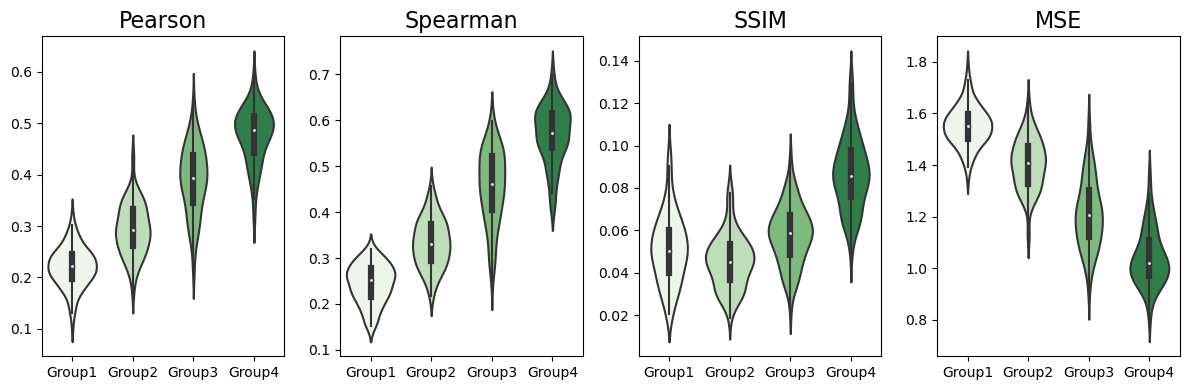

In [34]:
violinplot_charts(pearson_list_hicrep, spearman_list_hicrep, ssmi_list_hicrep, mse_list_hicrep,None,colors_cell)

## 2-SCL

group1


group2
group3
group4


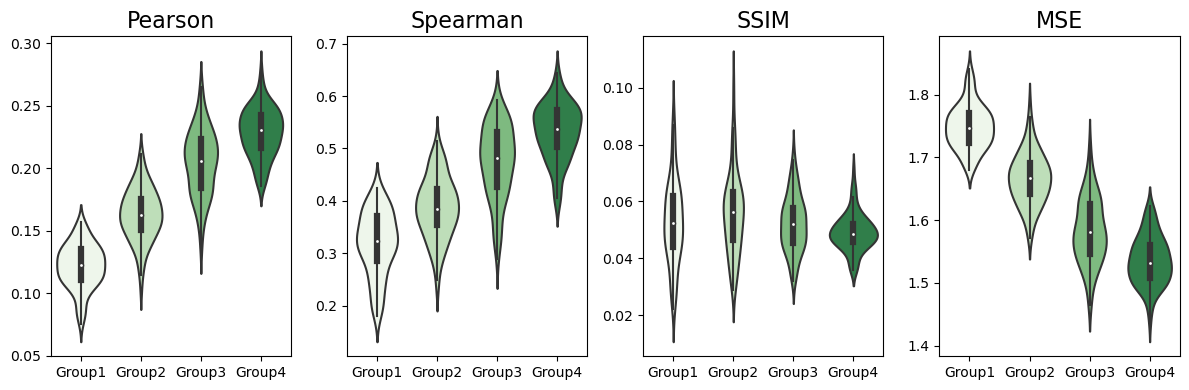

In [19]:
group_list = np.arange(1,5)
pearson_list_scl = []
spearman_list_scl = []
ssmi_list_scl = []
mse_list_scl = []
for group in group_list:
    print(f"group{group}")
    matrix_scl = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/scl/scl_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_scl[i]) for i in range(matrix_scl.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_scl.append(pearsons_raw)
    spearman_list_scl.append(spearmans_raw)
    ssmi_list_scl.append(ssmis_raw)
    mse_list_scl.append(mses_raw)
violinplot_charts(pearson_list_scl, spearman_list_scl, ssmi_list_scl, mse_list_scl,None,colors_cell)

## 3-snap Hi-C

group1


group2
group3
group4


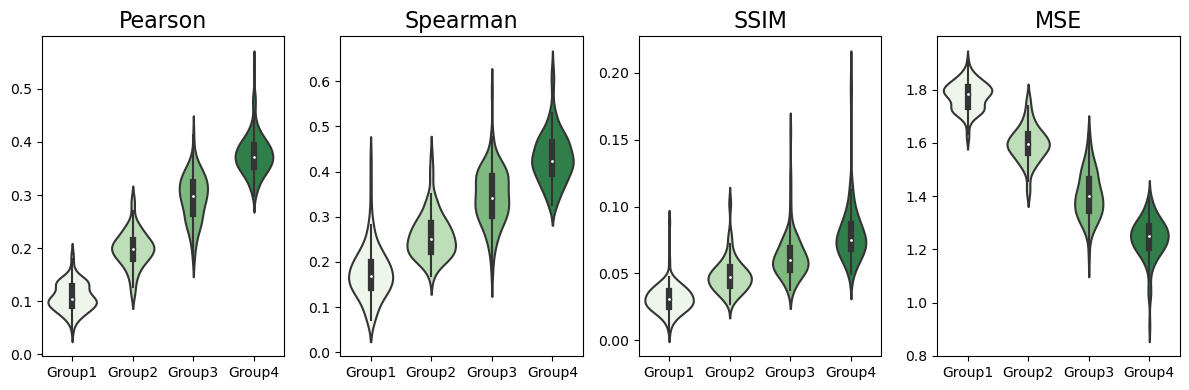

In [20]:
group_list = np.arange(1,5)
pearson_list_snap = []
spearman_list_snap = []
ssmi_list_snap = []
mse_list_snap = []
for group in group_list:
    print(f"group{group}")
    matrix_snap = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/snap/snap_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_snap[i]) for i in range(matrix_snap.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_snap.append(pearsons_raw)
    spearman_list_snap.append(spearmans_raw)
    ssmi_list_snap.append(ssmis_raw)
    mse_list_snap.append(mses_raw)
violinplot_charts(pearson_list_snap, spearman_list_snap, ssmi_list_snap, mse_list_snap,None,colors_cell)

## 4-genomDISCO

group1


group2
group3
group4


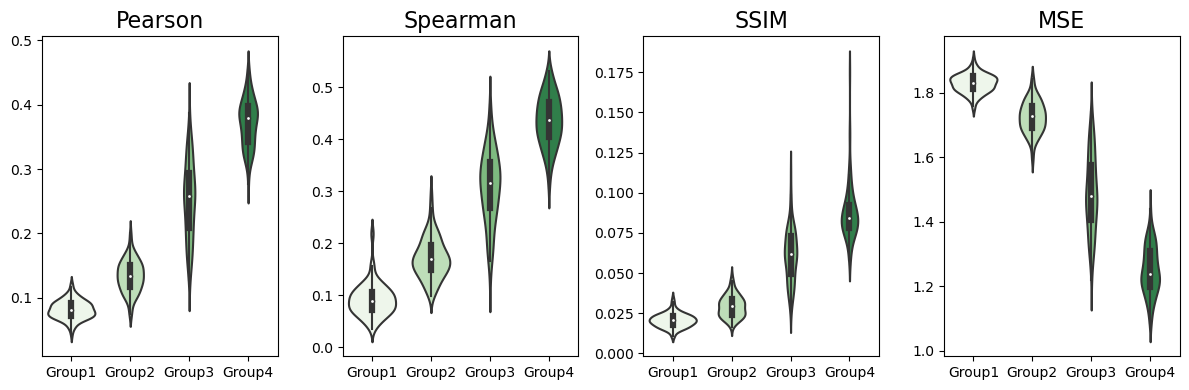

In [21]:
group_list = np.arange(1,5)
pearson_list_disco = []
spearman_list_disco = []
ssmi_list_disco = []
mse_list_disco = []
for group in group_list:
    print(f"group{group}")
    matrix_genomdisco = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/genomdisco/genomdisco_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_genomdisco[i]) for i in range(matrix_genomdisco.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_disco.append(pearsons_raw)
    spearman_list_disco.append(spearmans_raw)
    ssmi_list_disco.append(ssmis_raw)
    mse_list_disco.append(mses_raw)
violinplot_charts(pearson_list_disco, spearman_list_disco, ssmi_list_disco, mse_list_disco,None,colors_cell)

## 5-ctg

In [24]:
group = 1
matrix_ctg = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/ctg/ctg_imputed_{target}_group{group}.npy")

In [27]:
def plot_matrix(mat,title,cmap,vmin,vmax,show):
    plt.figure(figsize=(4,4))
    plt.imshow(mat,interpolation='nearest',cmap=cmap,vmin=vmin,vmax=vmax)
    if show:
        plt.colorbar()
    plt.title(title)
    #不显示刻度
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [33]:
matrix_ctg[0]

array([[        nan, -0.80145896, -0.74545118, ..., -0.72936156,
        -0.84598309, -0.77209828],
       [-0.80145896,         nan, -0.42642252, ..., -0.8828639 ,
        -0.83915166, -0.83519698],
       [-0.74545118, -0.42642252,         nan, ..., -0.84492477,
        -0.79478426, -0.76100465],
       ...,
       [-0.72936156, -0.8828639 , -0.84492477, ...,         nan,
        -0.91954134, -0.68802367],
       [-0.84598309, -0.83915166, -0.79478426, ..., -0.91954134,
                nan, -0.86020842],
       [-0.77209828, -0.83519698, -0.76100465, ..., -0.68802367,
        -0.86020842,         nan]])

group1


group2
group3
group4


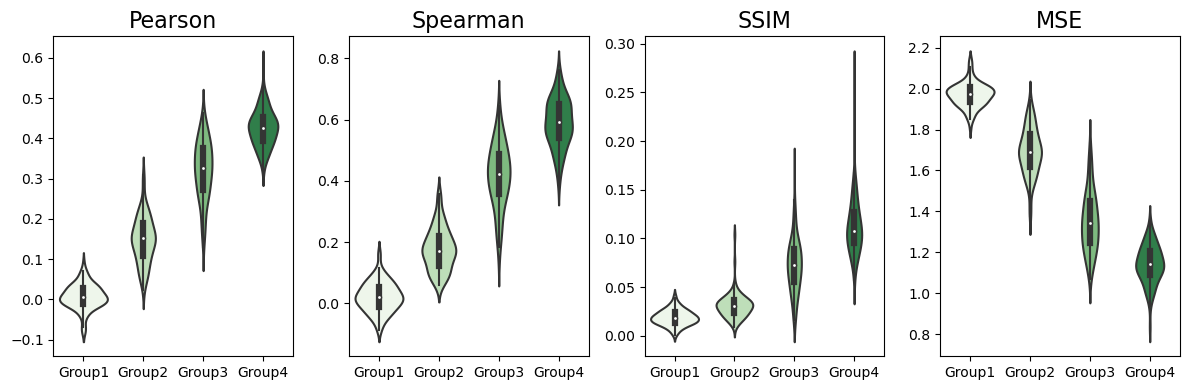

In [36]:
group_list = np.arange(1,5)
pearson_list_ctg = []
spearman_list_ctg = []
ssmi_list_ctg = []
mse_list_ctg = []
for group in group_list:
    print(f"group{group}")
    matrix_ctg = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/ctg/ctg_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_ctg[i]) for i in range(matrix_ctg.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_ctg.append(pearsons_raw)
    spearman_list_ctg.append(spearmans_raw)
    ssmi_list_ctg.append(ssmis_raw)
    mse_list_ctg.append(mses_raw)
violinplot_charts(pearson_list_ctg, spearman_list_ctg, ssmi_list_ctg, mse_list_ctg,None,colors_cell)

## 6-Schicluster

group1
group2
group3
group4


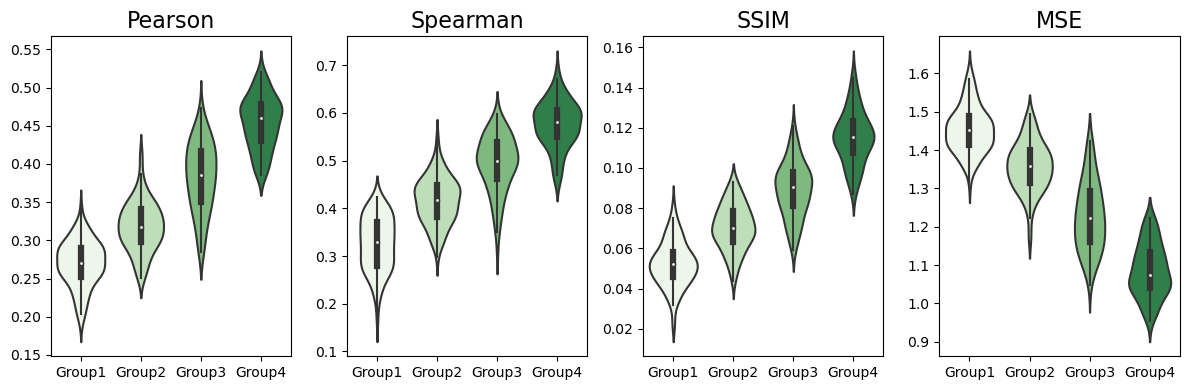

In [37]:
group_list = np.arange(1,5)
pearson_list_hicluster = []
spearman_list_hicluster = []
ssmi_list_hicluster = []
mse_list_hicluster = []
for group in group_list:
    print(f"group{group}")
    matrix_hicluster = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/schicluster/schicluster_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_hicluster[i]) for i in range(matrix_hicluster.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_hicluster.append(pearsons_raw)
    spearman_list_hicluster.append(spearmans_raw)
    ssmi_list_hicluster.append(ssmis_raw)
    mse_list_hicluster.append(mses_raw)
violinplot_charts(pearson_list_hicluster, spearman_list_hicluster, ssmi_list_hicluster, mse_list_hicluster,None,colors_cell)

## 7-Higashi

group1
group2
group3
group4


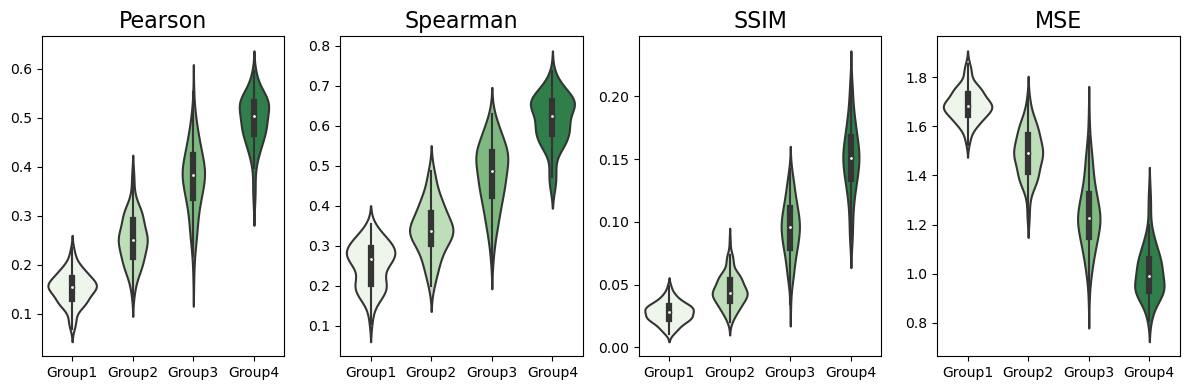

In [38]:
group_list = np.arange(1,5)
pearson_list_higashi = []
spearman_list_higashi = []
ssmi_list_higashi = []
mse_list_higashi = []
for group in group_list:
    print(f"group{group}")
    matrix_higashi = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/Higashi/higashi_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_higashi[i][0:243,0:243]) for i in range(matrix_ctg.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_higashi.append(pearsons_raw)
    spearman_list_higashi.append(spearmans_raw)
    ssmi_list_higashi.append(ssmis_raw)
    mse_list_higashi.append(mses_raw)
violinplot_charts(pearson_list_higashi, spearman_list_higashi, ssmi_list_higashi, mse_list_higashi,None,colors_cell)

## 8-HiCplus

group1
group2
group3
group4


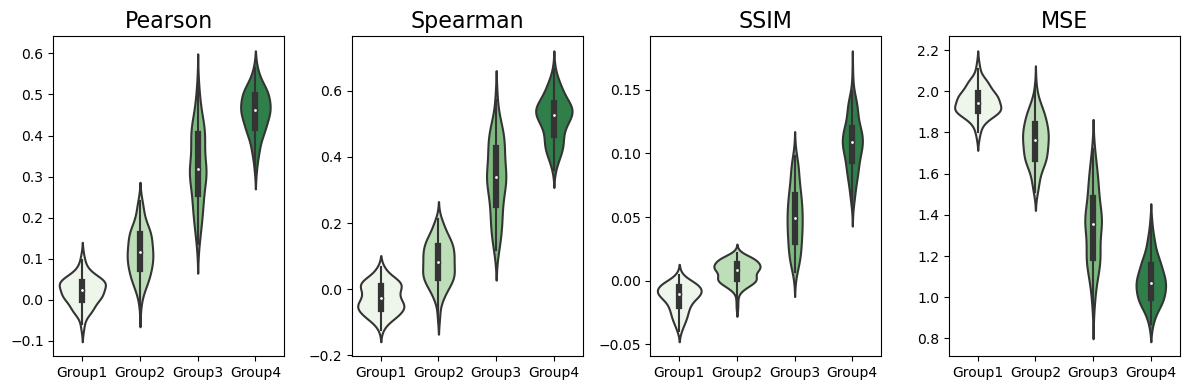

In [39]:
group_list = np.arange(1,5)
pearson_list_hicplus = []
spearman_list_hicplus = []
ssmi_list_hicplus = []
mse_list_hicplus = []
for group in group_list:
    print(f"group{group}")
    matrix_hicplus = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/hicplus/hicplus_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_hicplus[i][0:243,0:243]) for i in range(matrix_hicplus.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_hicplus.append(pearsons_raw)
    spearman_list_hicplus.append(spearmans_raw)
    ssmi_list_hicplus.append(ssmis_raw)
    mse_list_hicplus.append(mses_raw)
violinplot_charts(pearson_list_hicplus, spearman_list_hicplus, ssmi_list_hicplus, mse_list_hicplus,None,colors_cell)

In [54]:
len(pearson_list_hicplus)

4

## 9-DeepHi-C

group1


group2
group3
group4


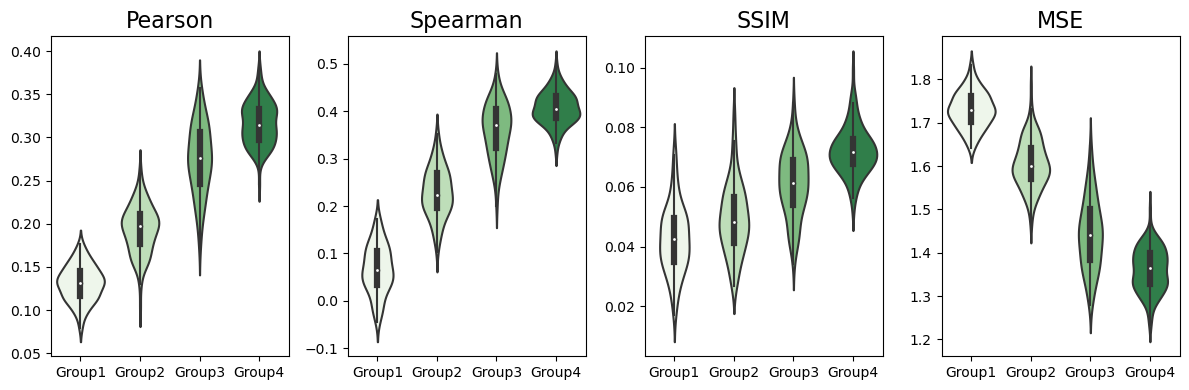

In [40]:
group_list = np.arange(1,5)
pearson_list_deep = []
spearman_list_deep = []
ssmi_list_deep = []
mse_list_deep = []
for group in group_list:
    print(f"group{group}")
    matrix_deep = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/deephic/deephic_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_deep[i][0:243,0:243]) for i in range(matrix_ctg.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_deep.append(pearsons_raw)
    spearman_list_deep.append(spearmans_raw)
    ssmi_list_deep.append(ssmis_raw)
    mse_list_deep.append(mses_raw)
violinplot_charts(pearson_list_deep, spearman_list_deep, ssmi_list_deep, mse_list_deep,None,colors_cell)

## 10-HiCImpute

group1
group2
group3
group4


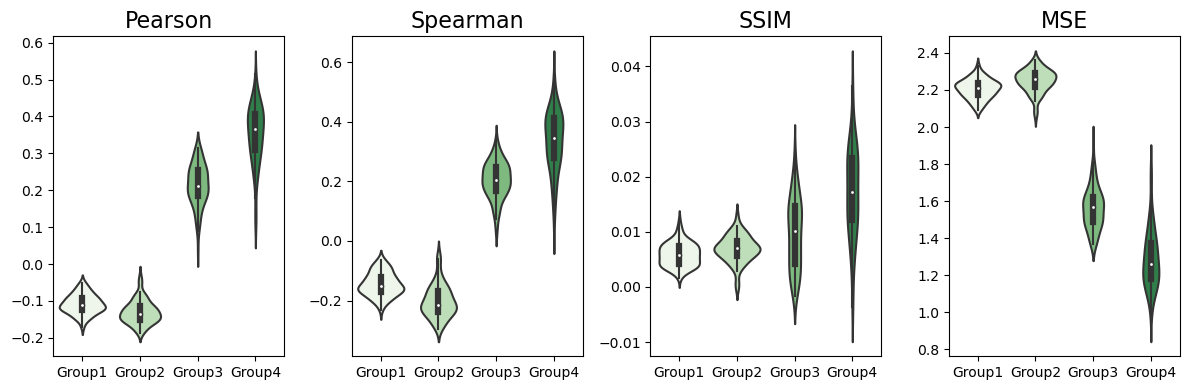

In [41]:
#config
target = "Cell2020"
prob_matrix = np.load(f"/shareb/mliu/evaluate_impute/data/simulation_hic/{target}/prob/{target}_prob_matrix.npy")


group_list = np.arange(1,5)
pearson_list_hicimpute = []
spearman_list_hicimpute = []
ssmi_list_hicimpute = []
mse_list_hicimpute = []
for group in group_list:
    print(f"group{group}")
    matrix_ctg = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/hicimpute/hicimputed_{target}_{group}.npy")
    pairs = [(prob_matrix[i], matrix_ctg[i]) for i in range(matrix_ctg.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_hicimpute.append(pearsons_raw)
    spearman_list_hicimpute.append(spearmans_raw)
    ssmi_list_hicimpute.append(ssmis_raw)
    mse_list_hicimpute.append(mses_raw)
violinplot_charts(pearson_list_hicimpute, spearman_list_hicimpute, ssmi_list_hicimpute, mse_list_hicimpute,None,colors_cell)

## 11-hickit

group1


group2
group3
group4


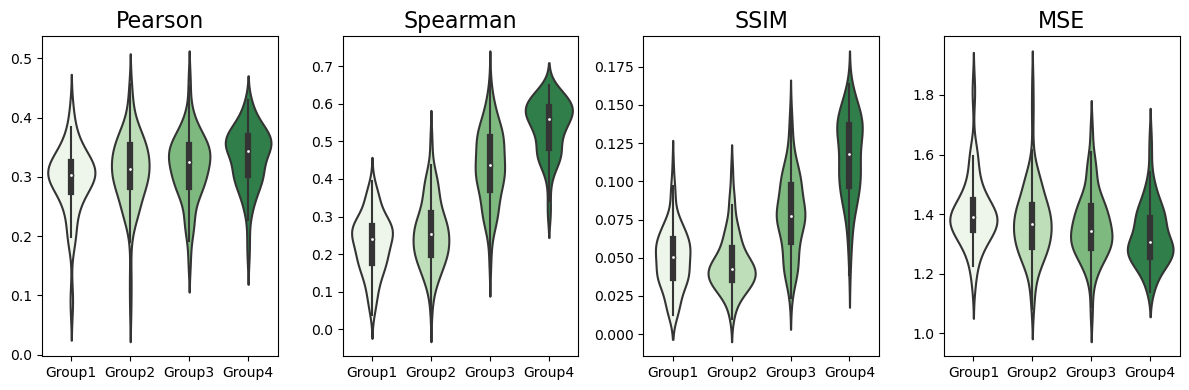

In [46]:



group_list = np.arange(1,5)
pearson_list_hickit = []
spearman_list_hickit = []
ssmi_list_hickit = []
mse_list_hickit = []
for group in group_list:
    print(f"group{group}")
    matrix_hickit = np.load(f"/shareb/mliu/evaluate_impute/data/imputed_data/hickit/hickit_imputed_{target}_group{group}.npy")
    pairs = [(prob_matrix[i], matrix_hickit[i]) for i in range(matrix_hickit.shape[0])]

    with multiprocessing.Pool(10) as pool:
        results = pool.map(mat_cor, pairs)

    pearsons_raw, spearmans_raw, ssmis_raw, mses_raw = zip(*results)
    pearson_list_hickit.append(pearsons_raw)
    spearman_list_hickit.append(spearmans_raw)
    ssmi_list_hickit.append(ssmis_raw)
    mse_list_hickit.append(mses_raw)
violinplot_charts(pearson_list_hickit, spearman_list_hickit, ssmi_list_hickit, mse_list_hickit,None,colors_cell)

## 总

In [77]:
pearson_list1 = [pearson_list_raw[0],pearson_list_hicrep[0],pearson_list_scl[0],pearson_list_snap[0],pearson_list_disco[0],pearson_list_ctg[0],pearson_list_hicluster[0],pearson_list_higashi[0],pearson_list_hicplus[0],pearson_list_deep[0],pearson_list_hickit[0]]
spearman_list1 = [spearman_list_raw[0],spearman_list_hicrep[0],spearman_list_scl[0],spearman_list_snap[0],spearman_list_disco[0],spearman_list_ctg[0],spearman_list_hicluster[0],spearman_list_higashi[0],spearman_list_hicplus[0],spearman_list_deep[0],spearman_list_hickit[0]]
ssmi_list1 = [ssmi_list_raw[0],ssmi_list_hicrep[0],ssmi_list_scl[0],ssmi_list_snap[0],ssmi_list_disco[0],ssmi_list_ctg[0],ssmi_list_hicluster[0],ssmi_list_higashi[0],ssmi_list_hicplus[0],ssmi_list_deep[0],ssmi_list_hickit[0]]
mse_list1 = [mse_list_raw[0],mse_list_hicrep[0],mse_list_scl[0],mse_list_snap[0],mse_list_disco[0],mse_list_ctg[0],mse_list_hicluster[0],mse_list_higashi[0],mse_list_hicplus[0],mse_list_deep[0],mse_list_hickit[0]]


pearson_list2 = [pearson_list_raw[1],pearson_list_hicrep[1],pearson_list_scl[1],pearson_list_snap[1],pearson_list_disco[1],pearson_list_ctg[1],pearson_list_hicluster[1],pearson_list_higashi[1],pearson_list_hicplus[1],pearson_list_deep[1],pearson_list_hickit[1]]
spearman_list2 = [spearman_list_raw[1],spearman_list_hicrep[1],spearman_list_scl[1],spearman_list_snap[1],spearman_list_disco[1],spearman_list_ctg[1],spearman_list_hicluster[1],spearman_list_higashi[1],spearman_list_hicplus[1],spearman_list_deep[1],spearman_list_hickit[1]]
ssmi_list2 = [ssmi_list_raw[1],ssmi_list_hicrep[1],ssmi_list_scl[1],ssmi_list_snap[1],ssmi_list_disco[1],ssmi_list_ctg[1],ssmi_list_hicluster[1],ssmi_list_higashi[1],ssmi_list_hicplus[1],ssmi_list_deep[1],ssmi_list_hickit[1]]
mse_list2 = [mse_list_raw[1],mse_list_hicrep[1],mse_list_scl[1],mse_list_snap[1],mse_list_disco[1],mse_list_ctg[1],mse_list_hicluster[1],mse_list_higashi[1],mse_list_hicplus[1],mse_list_deep[1],mse_list_hickit[1]]


pearson_list3 = [pearson_list_raw[2],pearson_list_hicrep[2],pearson_list_scl[2],pearson_list_snap[2],pearson_list_disco[2],pearson_list_ctg[2],pearson_list_hicluster[2],pearson_list_higashi[2],pearson_list_hicplus[2],pearson_list_deep[2],pearson_list_hickit[2]]
spearman_list3 = [spearman_list_raw[2],spearman_list_hicrep[2],spearman_list_scl[2],spearman_list_snap[2],spearman_list_disco[2],spearman_list_ctg[2],spearman_list_hicluster[2],spearman_list_higashi[2],spearman_list_hicplus[2],spearman_list_deep[2],spearman_list_hickit[2]]
ssmi_list3 = [ssmi_list_raw[2],ssmi_list_hicrep[2],ssmi_list_scl[2],ssmi_list_snap[2],ssmi_list_disco[2],ssmi_list_ctg[2],ssmi_list_hicluster[2],ssmi_list_higashi[2],ssmi_list_hicplus[2],ssmi_list_deep[2],ssmi_list_hickit[2]]
mse_list3 = [mse_list_raw[2],mse_list_hicrep[2],mse_list_scl[2],mse_list_snap[2],mse_list_disco[2],mse_list_ctg[2],mse_list_hicluster[2],mse_list_higashi[2],mse_list_hicplus[2],mse_list_deep[2],mse_list_hickit[2]]

pearson_list4 = [pearson_list_raw[3],pearson_list_hicrep[3],pearson_list_scl[3],pearson_list_snap[3],pearson_list_disco[3],pearson_list_ctg[3],pearson_list_hicluster[3],pearson_list_higashi[3],pearson_list_hicplus[3],pearson_list_deep[3],pearson_list_hickit[3]]
spearman_list4 = [spearman_list_raw[3],spearman_list_hicrep[3],spearman_list_scl[3],spearman_list_snap[3],spearman_list_disco[3],spearman_list_ctg[3],spearman_list_hicluster[3],spearman_list_higashi[3],spearman_list_hicplus[3],spearman_list_deep[3],spearman_list_hickit[3]]
ssmi_list4 = [ssmi_list_raw[3],ssmi_list_hicrep[3],ssmi_list_scl[3],ssmi_list_snap[3],ssmi_list_disco[3],ssmi_list_ctg[3],ssmi_list_hicluster[3],ssmi_list_higashi[3],ssmi_list_hicplus[3],ssmi_list_deep[3],ssmi_list_hickit[3]]
mse_list4 = [mse_list_raw[3],mse_list_hicrep[3],mse_list_scl[3],mse_list_snap[3],mse_list_disco[3],mse_list_ctg[3],mse_list_hicluster[3],mse_list_higashi[3],mse_list_hicplus[3],mse_list_deep[3],mse_list_hickit[3]]

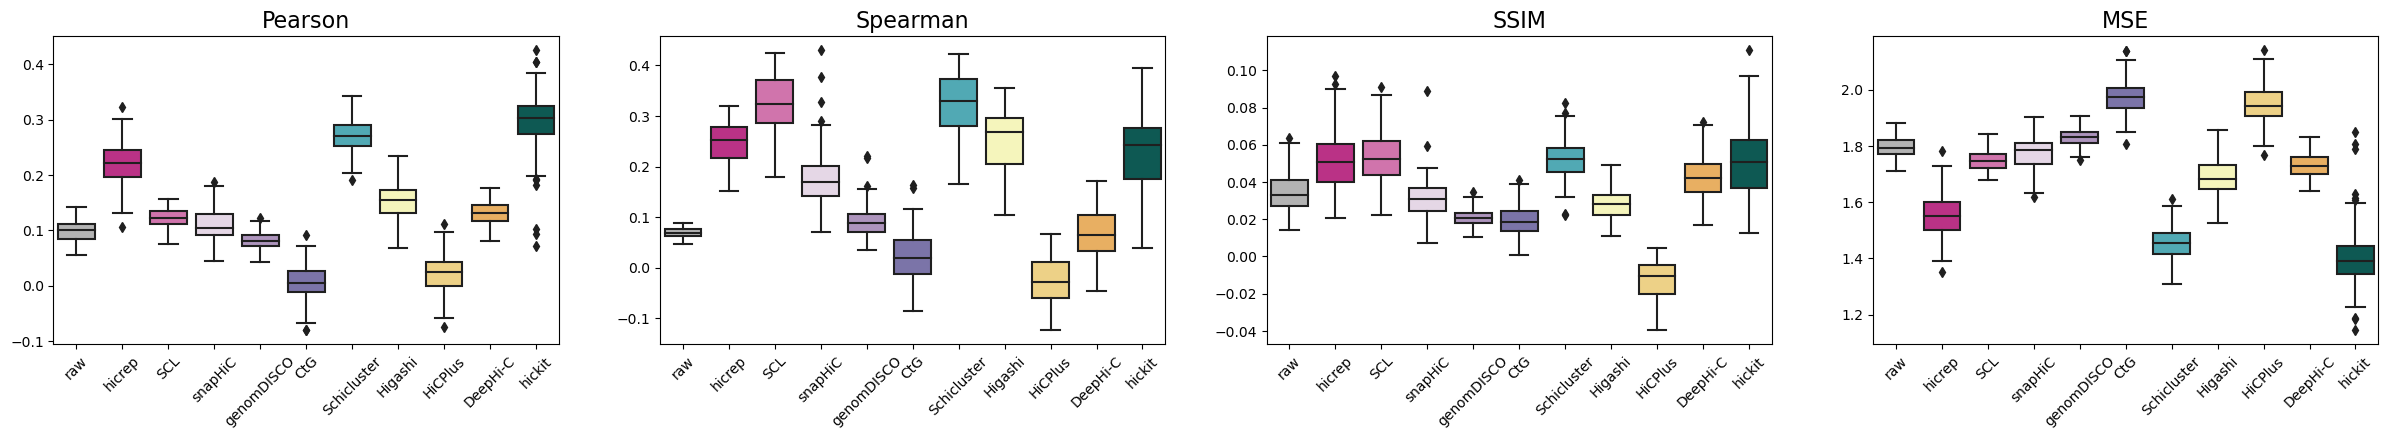

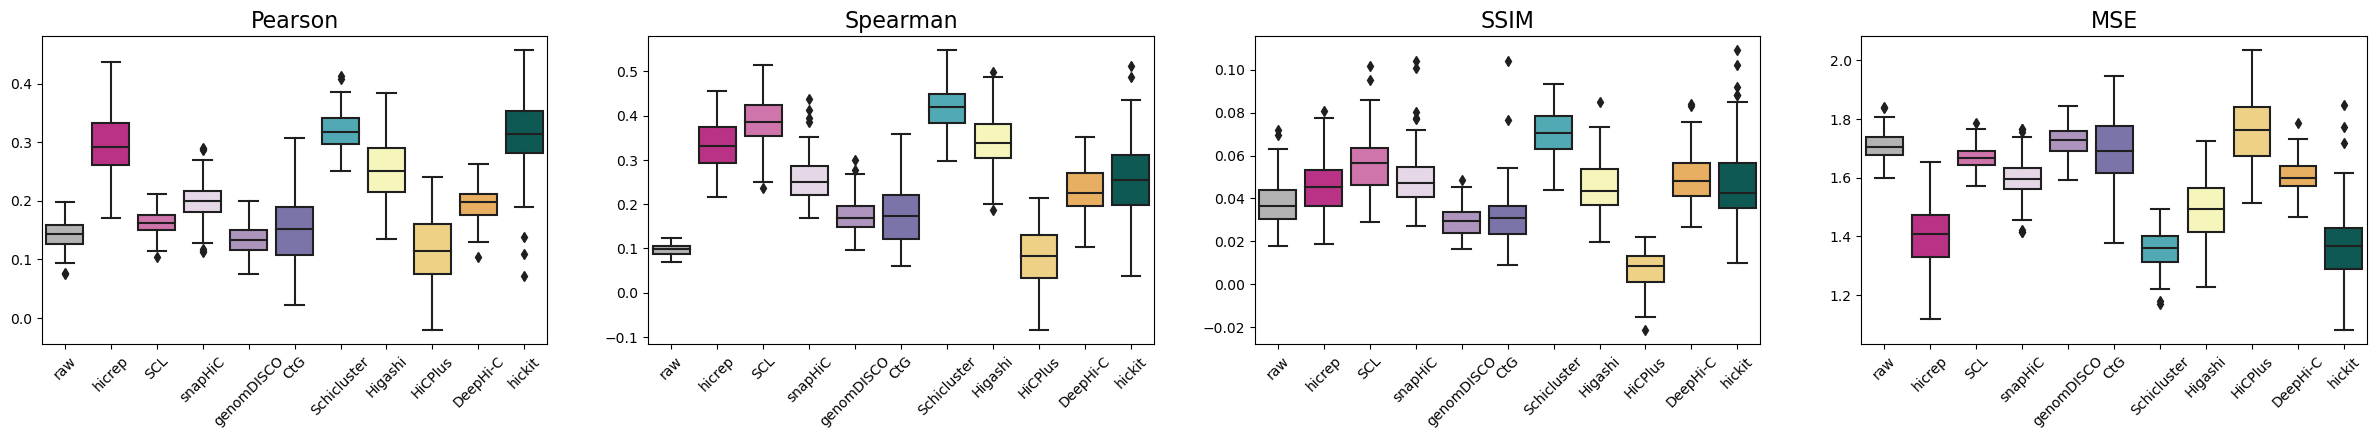

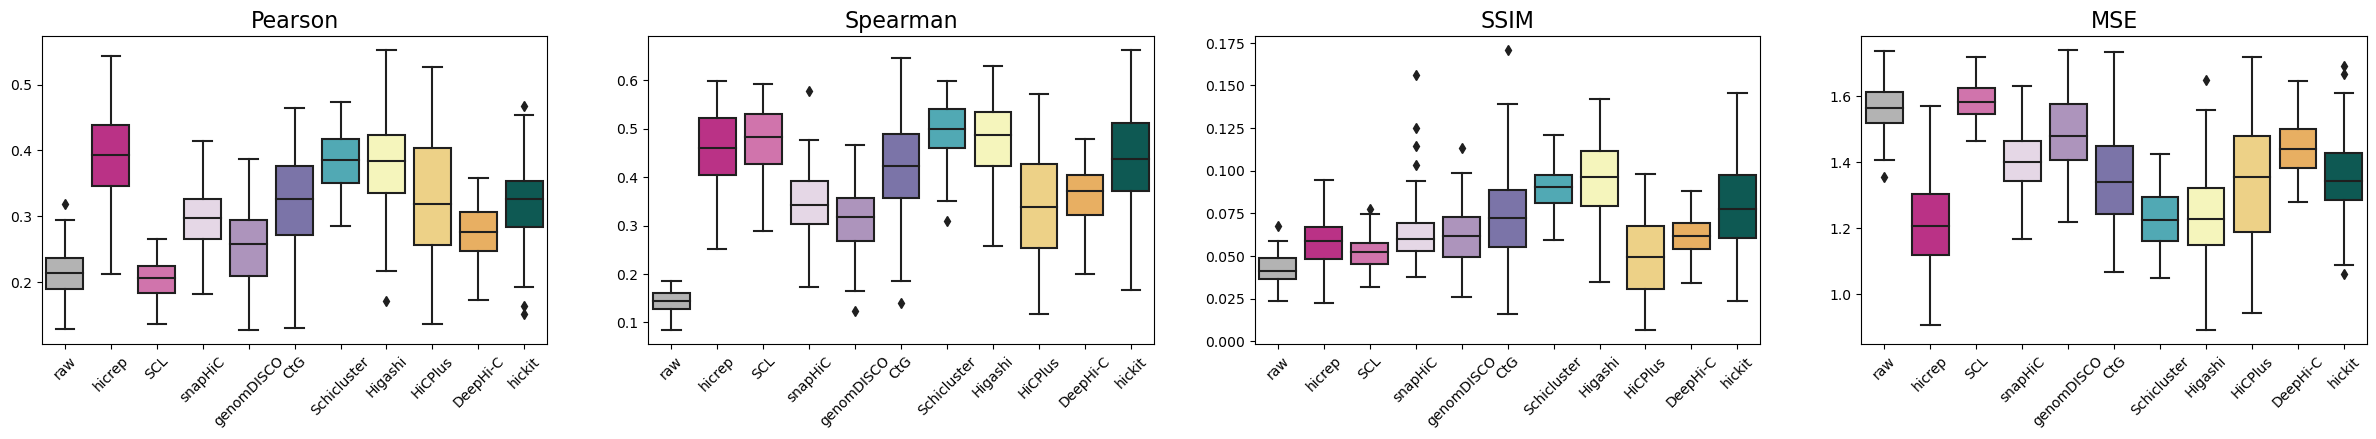

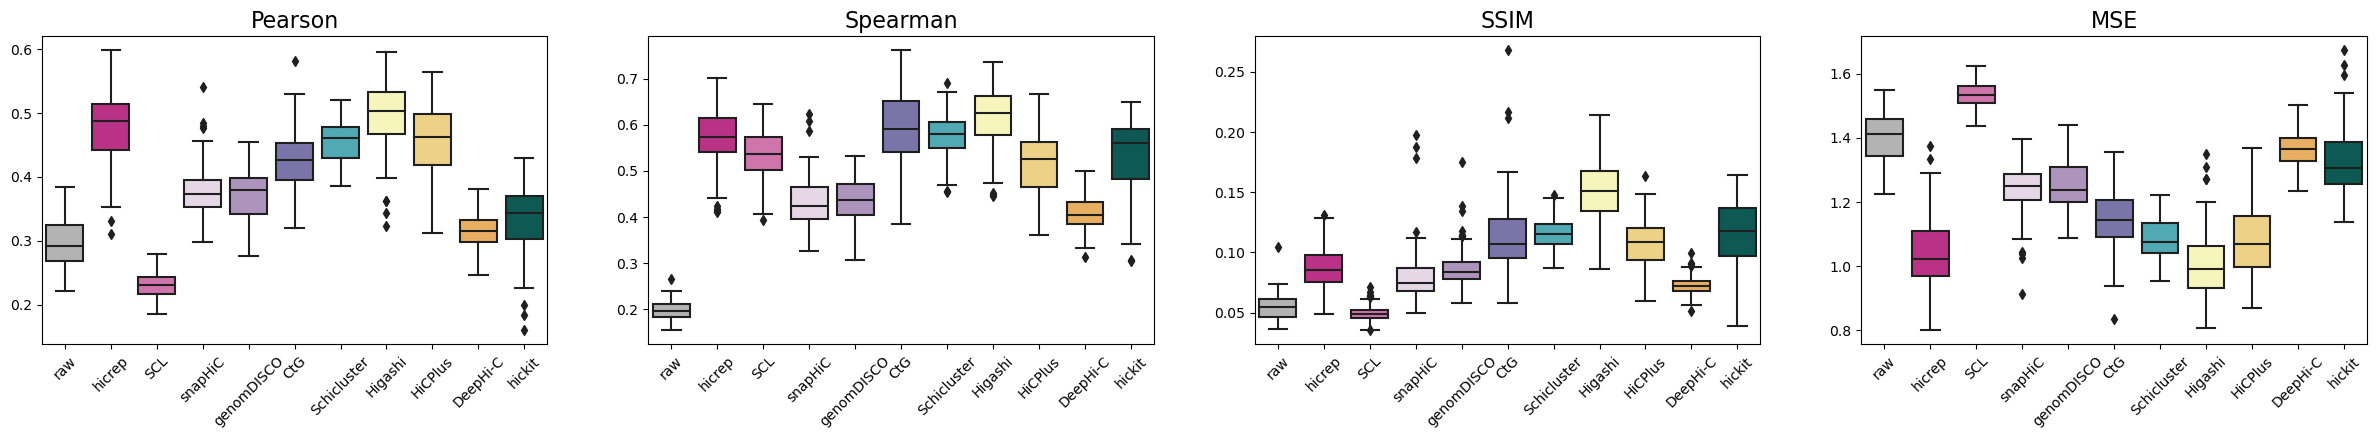

In [79]:
tool_list = ["raw","hicrep","SCL","snapHiC","genomDISCO","CtG","Schicluster","Higashi","HiCPlus","DeepHi-C","hickit"]
plot_groups(pearson_list1,spearman_list1,ssmi_list1,mse_list1,"Group1",tool_list)
plot_groups(pearson_list2,spearman_list2,ssmi_list2,mse_list2,"Group2",tool_list)
plot_groups(pearson_list3,spearman_list3,ssmi_list3,mse_list3,"Group3",tool_list)
plot_groups(pearson_list4,spearman_list4,ssmi_list4,mse_list4,"Group4",tool_list)